In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score


In [2]:
from sentence_transformers import SentenceTransformer

# –ü—Ä–æ–≤–µ—Ä—è–µ–º, –∑–∞–≥—Ä—É–∂–∞–µ—Ç—Å—è –ª–∏ BERT
model_bert = SentenceTransformer('all-MiniLM-L6-v2')
print("BERT –∑–∞–≥—Ä—É–∂–µ–Ω —É—Å–ø–µ—à–Ω–æ!")

BERT –∑–∞–≥—Ä—É–∂–µ–Ω —É—Å–ø–µ—à–Ω–æ!


In [3]:
# –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –∏–∑ CSV —Ñ–∞–π–ª–æ–≤
cryptopanic_news = pd.read_csv(r'data/news/cryptopanic_news.csv')
currency = pd.read_csv(r'data/newscurrency.csv')
news_currency = pd.read_csv(r'data/news/news__currency.csv')
source = pd.read_csv(r'data/news/source.csv')

df_BTC_USDT = pd.read_csv(r"data/BTC_USDT_USDT_1h_ohlcv.csv")
df_ETH_USDT = pd.read_csv(r"data/ETH_USDT_USDT_1h_ohlcv.csv")
df_SOL_USDT = pd.read_csv(r"data/SOL_USDT_USDT_1h_ohlcv.csv")

In [4]:
df_BTC_USDT['code'] = 'BTC'
df_ETH_USDT['code'] = 'ETH'
df_SOL_USDT['code'] = 'SOL'

df_price  = pd.concat([df_BTC_USDT, df_ETH_USDT, df_SOL_USDT ], ignore_index=True)

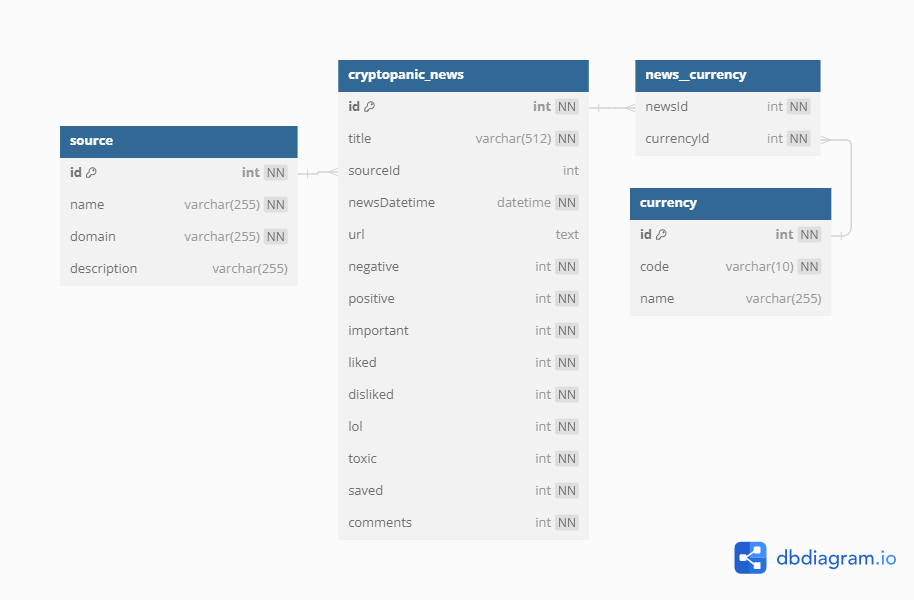

In [5]:
# –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —Å–æ–µ–¥–∏–Ω–µ–Ω–∏–π
df_news = cryptopanic_news.merge(news_currency, left_on='id', right_on='newsId') \
                              .merge(currency, left_on='currencyId', right_on='id') \
#                               .merge(source, left_on='sourceId', right_on='id') 



# –ü—Ä–∏–º–µ—Ä–Ω—ã–µ –Ω–∞–∑–≤–∞–Ω–∏—è —Å—Ç–æ–ª–±—Ü–æ–≤
df_news["newsDatetime"] = pd.to_datetime(df_news["newsDatetime"])  # –î–∞—Ç–∞ –Ω–æ–≤–æ—Å—Ç–∏
df_price["timestamp"] = pd.to_datetime(df_price["timestamp"])  # –í—Ä–µ–º–µ–Ω–Ω–∞—è –º–µ—Ç–∫–∞ —Ü–µ–Ω—ã

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ –≤—Ä–µ–º–µ–Ω–∏ (–æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ –¥–ª—è merge_asof)
df_news = df_news.sort_values("newsDatetime")
df_price = df_price.sort_values("timestamp")

# –î–∂–æ–π–Ω–∏–º –ø–æ –≤—Ä–µ–º–µ–Ω–∏ —Å —É—á–µ—Ç–æ–º "code"
df_1 = pd.merge_asof(
    df_news, df_price, 
    left_on="newsDatetime", 
    right_on="timestamp", 
    by="code"  # –û–±—ä–µ–¥–∏–Ω—è–µ–º —Ç–æ–ª—å–∫–æ —Å—Ç—Ä–æ–∫–∏ —Å –æ–¥–∏–Ω–∞–∫–æ–≤—ã–º –∫–æ–¥–æ–º –≤–∞–ª—é—Ç—ã
)

df_2 = df_1[~df_1['open'].isna()]
len(df_1), len(df_2)

(277481, 41091)

### create target

In [6]:
N = 6  # –ì–æ—Ä–∏–∑–æ–Ω—Ç –ø—Ä–æ–≥–Ω–æ–∑–∞

# –î–µ–ª–∞–µ–º –∫–æ–ø–∏—é —Ü–µ–Ω –∏ —Å–¥–≤–∏–≥–∞–µ–º –≤—Ä–µ–º—è –≤–ø–µ—Ä—ë–¥ –Ω–∞ N —á–∞—Å–æ–≤
df_price_shifted = df_2[["code", "timestamp", "close"]].copy()
df_price_shifted["timestamp"] += pd.Timedelta(hours=N)

# –î–∂–æ–π–Ω–∏–º —Å `df_2`, —á—Ç–æ–±—ã –¥–æ–±–∞–≤–∏—Ç—å —Ü–µ–Ω—É —á–µ—Ä–µ–∑ N —á–∞—Å–æ–≤
df_2 = pd.merge_asof(
    df_2.sort_values("newsDatetime"), 
    df_price_shifted.sort_values("timestamp"), 
    left_on="newsDatetime", 
    right_on="timestamp", 
    by="code", 
    suffixes=("", f"_t{N}")  
)

# –°–æ–∑–¥–∞—ë–º –±–∏–Ω–∞—Ä–Ω—ã–π —Ç–∞—Ä–≥–µ—Ç: 1 = —Ü–µ–Ω–∞ –≤—ã—Ä–æ—Å–ª–∞, 0 = —Ü–µ–Ω–∞ —É–ø–∞–ª–∞
df_2[f"target_{N}h_binary"] = (df_2[f"close_t{N}"] > df_2["close"]).astype(int)

df_2[[f"target_{N}h_binary", "newsDatetime", "close", f"close_t{N}"]].head(3)

target_6h_binary        newsDatetime    close  close_t6
0                 0 2020-04-16 05:02:12  6632.80       NaN
1                 0 2020-05-13 11:16:19   190.96       NaN
2                 0 2020-05-14 23:06:34   203.31    190.96

In [7]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41091 entries, 0 to 41090
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_x              41091 non-null  int64         
 1   title             41091 non-null  object        
 2   sourceId          41091 non-null  int64         
 3   newsDatetime      41091 non-null  datetime64[ns]
 4   url               41091 non-null  object        
 5   negative          41091 non-null  int64         
 6   positive          41091 non-null  int64         
 7   important         41091 non-null  int64         
 8   liked             41091 non-null  int64         
 9   disliked          41091 non-null  int64         
 10  lol               41091 non-null  int64         
 11  toxic             41091 non-null  int64         
 12  saved             41091 non-null  int64         
 13  comments          41091 non-null  int64         
 14  newsId            4109

In [8]:
df_2 = df_2.fillna(0)

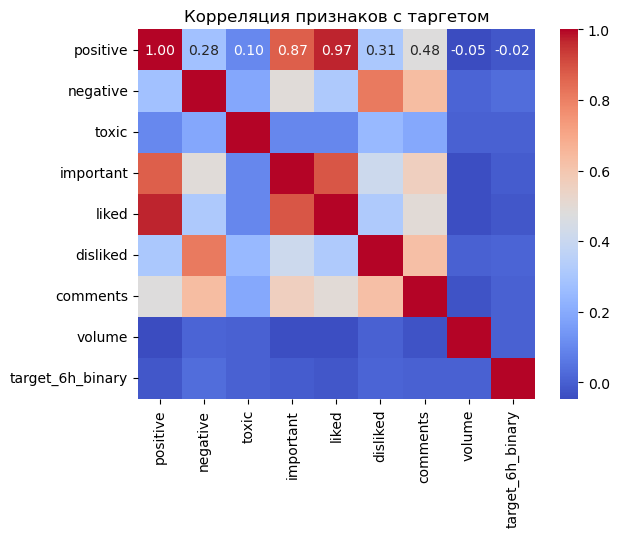

In [11]:
corr_matrix = df_2[['positive', 'negative', 'toxic', 'important', 'liked',
                    'disliked', 'comments', 'volume', 'target_6h_binary']].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å —Ç–∞—Ä–≥–µ—Ç–æ–º')
plt.show()

In [12]:
corr_matrix['target_6h_binary'].sort_values(ascending=False)

target_6h_binary    1.000000
negative            0.032622
disliked            0.012365
volume              0.004785
comments            0.004583
toxic               0.004465
important          -0.008983
liked              -0.021429
positive           -0.022307
Name: target_6h_binary, dtype: float64

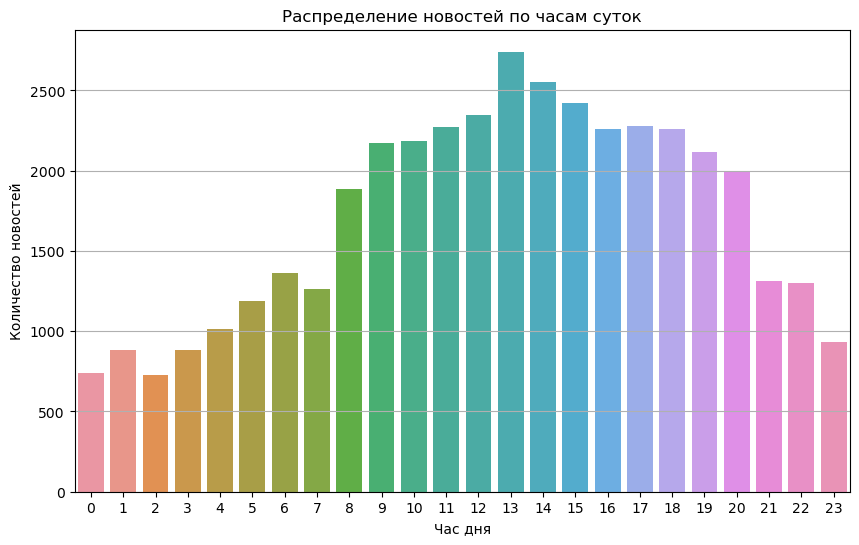

In [13]:
# –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –ø–æ —á–∞—Å–∞–º
plt.figure(figsize=(10, 6))
sns.countplot(x=df_2['newsDatetime'].dt.hour)
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –Ω–æ–≤–æ—Å—Ç–µ–π –ø–æ —á–∞—Å–∞–º —Å—É—Ç–æ–∫')
plt.xlabel('–ß–∞—Å –¥–Ω—è')
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–æ–≤–æ—Å—Ç–µ–π')
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()

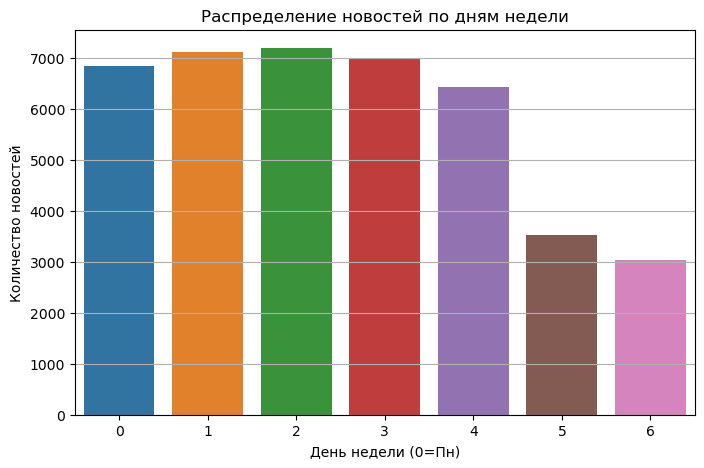

In [14]:
# –î–µ–Ω—å –Ω–µ–¥–µ–ª–∏: 0 - –ü–Ω, 6 - –í—Å
plt.figure(figsize=(8, 5))
sns.countplot(x=df_2['newsDatetime'].dt.weekday)
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –Ω–æ–≤–æ—Å—Ç–µ–π –ø–æ –¥–Ω—è–º –Ω–µ–¥–µ–ª–∏')
plt.xlabel('–î–µ–Ω—å –Ω–µ–¥–µ–ª–∏ (0=–ü–Ω)')
plt.ylabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –Ω–æ–≤–æ—Å—Ç–µ–π')
plt.grid(axis='y')
plt.show()

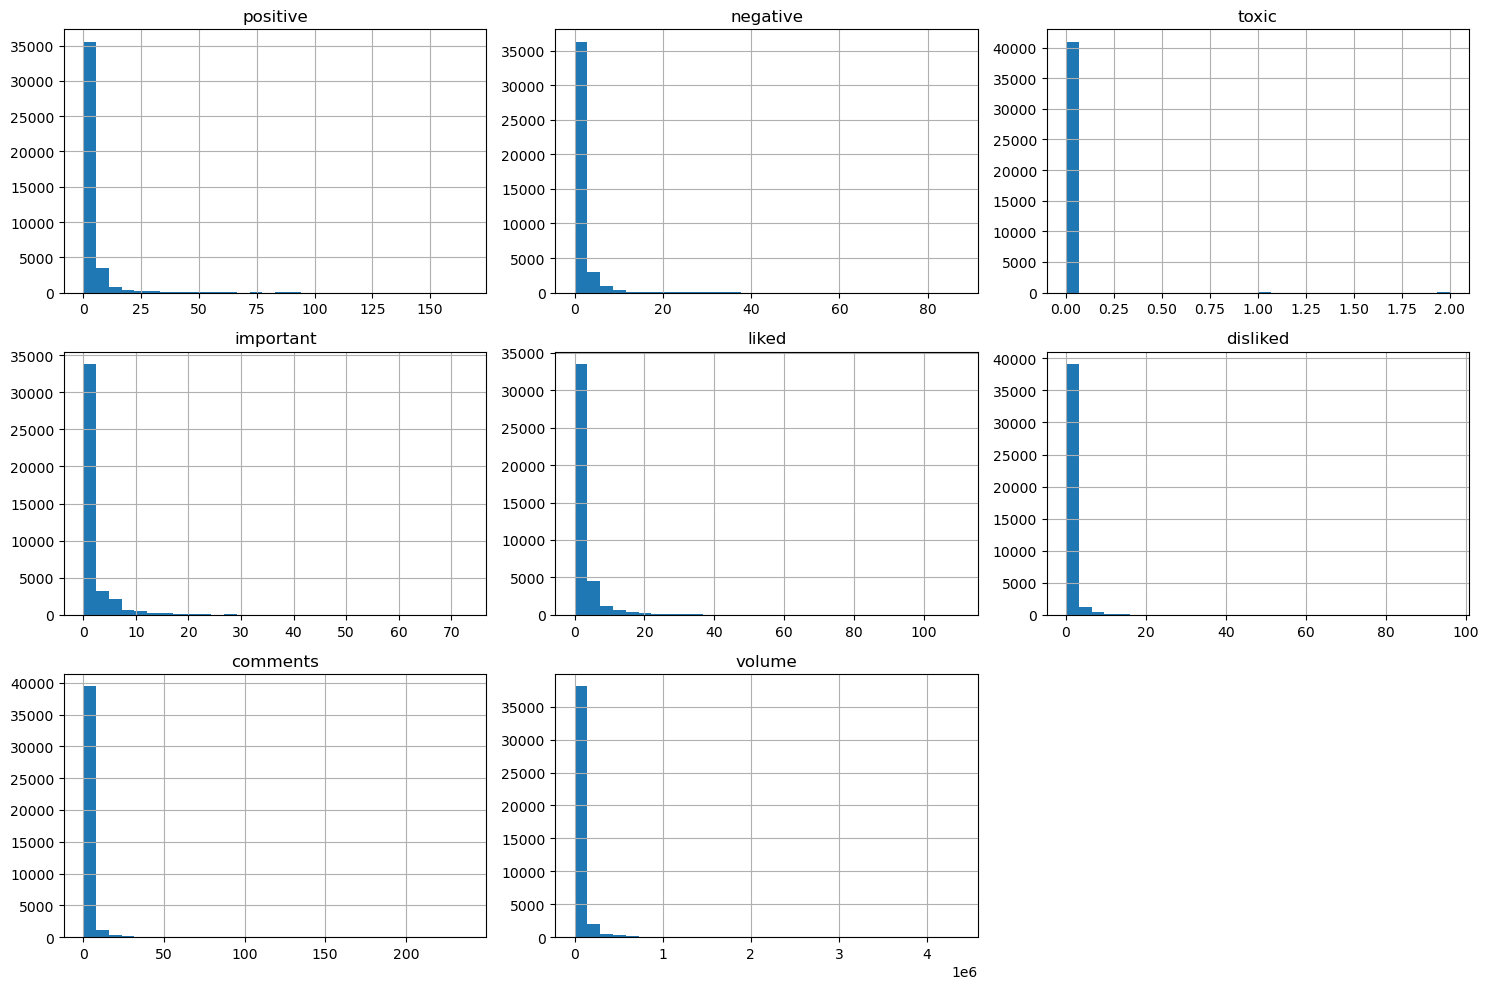

In [15]:
num_features = ["positive", "negative", "toxic", "important", "liked", "disliked", "comments", "volume"]
df_2[num_features].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [16]:
class_counts = df_2['target_6h_binary'].value_counts()
print("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ–±—ä–µ–∫—Ç–æ–≤ –ø–æ –∫–ª–∞—Å—Å–∞–º:\n", class_counts)

class_percent = df_2['target_6h_binary'].value_counts(normalize=True) * 100
print("\n–ü—Ä–æ—Ü–µ–Ω—Ç–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤:\n", class_percent.round(2))

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ–±—ä–µ–∫—Ç–æ–≤ –ø–æ –∫–ª–∞—Å—Å–∞–º:
 target_6h_binary
0    20688
1    20403
Name: count, dtype: int64

–ü—Ä–æ—Ü–µ–Ω—Ç–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤:
 target_6h_binary
0    50.35
1    49.65
Name: proportion, dtype: float64


In [21]:
N = 6  # –ì–æ—Ä–∏–∑–æ–Ω—Ç –ø—Ä–æ–≥–Ω–æ–∑–∞

# –í—ã–±–∏—Ä–∞–µ–º —Ñ–∏—á–∏ –¥–ª—è –º–æ–¥–µ–ª–∏
features = [
    "positive", "negative", "toxic", "important", "liked", 
    "disliked", "comments", "sourceId"
]

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤—Ä–µ–º—è –ø—É–±–ª–∏–∫–∞—Ü–∏–∏ –≤ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
df_2["hour"] = df_2["newsDatetime"].dt.hour  # –ß–∞—Å –¥–Ω—è
df_2["weekday"] = df_2["newsDatetime"].dt.weekday  # –î–µ–Ω—å –Ω–µ–¥–µ–ª–∏ (0=–ü–Ω, 6=–í—Å)
features += ["hour", "weekday"]

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ç–µ–∫—Å—Ç –∑–∞–≥–æ–ª–æ–≤–∫–æ–≤ –≤ TF-IDF
vectorizer = TfidfVectorizer(max_features=500)
X_text = vectorizer.fit_transform(df_2["title"].fillna(""))

# –°–æ–±–∏—Ä–∞–µ–º —Ñ–∏–Ω–∞–ª—å–Ω—ã–π –º–∞—Å—Å–∏–≤ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
X_numeric = df_2[features].fillna(0)
X = np.hstack((X_numeric, X_text.toarray()))
y = df_2[f"target_{N}h_binary"]

# –†–∞–∑–±–∏–≤–∞–µ–º –Ω–∞ train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# –û–±—É—á–∞–µ–º CatBoost
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=100)
model.fit(X_train, y_train)

# –ü–æ–ª—É—á–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∫–ª–∞—Å—Å–æ–≤ –∏ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–µ–π
y_pred = model.predict(X_test)                # ‚Üê –∫–ª–∞—Å—Å—ã 0 –∏–ª–∏ 1
y_pred_proba = model.predict_proba(X_test)[:, 1]  # ‚Üê –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –∫–ª–∞—Å—Å–∞ 1

# –°—á–∏—Ç–∞–µ–º –º–µ—Ç—Ä–∏–∫–∏
precision = precision_score(y_test, y_pred)
accuracy = model.score(X_test, y_test)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {auc:.4f}")

0:	learn: 0.6927328	total: 55.8ms	remaining: 27.8s
100:	learn: 0.6769750	total: 4.49s	remaining: 17.7s
200:	learn: 0.6567119	total: 8.95s	remaining: 13.3s
300:	learn: 0.6392455	total: 13.4s	remaining: 8.86s
400:	learn: 0.6232008	total: 17.8s	remaining: 4.41s
499:	learn: 0.6078434	total: 22.2s	remaining: 0us
Accuracy: 0.5667
Precision: 0.5659
Recall: 0.5380
ROC AUC: 0.5935


In [22]:
# –ü–æ–ª—É—á–∞–µ–º –∑–Ω–∞—á–∏–º–æ—Å—Ç—å
importances = model.get_feature_importance()
feature_names = features + list(vectorizer.get_feature_names_out())

# –°–æ–∑–¥–∞—ë–º —Ç–∞–±–ª–∏—Ü—É
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# –ü–æ–∫–∞–∂–µ–º —Ç–æ–ø-20
print(importance_df.head(20))

      Feature  Importance
8        hour    6.461804
9     weekday    4.163403
7    sourceId    3.520527
96    bitcoin    2.424731
1    negative    2.411712
0    positive    2.039271
4       liked    1.692626
179  ethereum    1.656906
443        to    1.640489
240        in    1.540591
140    crypto    1.436136
63        and    1.304945
351     price    1.115177
407    solana    1.087031
196       for    1.023666
436       the    1.004048
71         as    0.974883
325        on    0.911950
90      below    0.885604
323        of    0.844770


In [24]:

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤—Ä–µ–º—è –ø—É–±–ª–∏–∫–∞—Ü–∏–∏ –≤ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
df_2["hour"] = df_2["newsDatetime"].dt.hour  # –ß–∞—Å –¥–Ω—è
df_2["weekday"] = df_2["newsDatetime"].dt.weekday  # –î–µ–Ω—å –Ω–µ–¥–µ–ª–∏ (0=–ü–Ω, 6=–í—Å)
df_2["title_length"] = df_2["title"].apply(lambda x: len(str(x)))
df_2["is_night"] = df_2["hour"].apply(lambda x: 1 if x < 6 else 0)
df_2["is_weekend"] = df_2["weekday"].apply(lambda x: 1 if x >= 5 else 0)

# –î–æ–±–∞–≤–ª—è–µ–º –Ω–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –≤ —Å–ø–∏—Å–æ–∫
features += ["is_night", "is_weekend", "hour", "weekday", "title_length"]

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤—Ä–µ–º—è –ø—É–±–ª–∏–∫–∞—Ü–∏–∏ –≤ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
df_2["hour"] = df_2["newsDatetime"].dt.hour  # –ß–∞—Å –¥–Ω—è
df_2["weekday"] = df_2["newsDatetime"].dt.weekday  # –î–µ–Ω—å –Ω–µ–¥–µ–ª–∏ (0=–ü–Ω, 6=–í—Å)
features += ["hour", "weekday"]

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ç–µ–∫—Å—Ç –∑–∞–≥–æ–ª–æ–≤–∫–æ–≤ –≤ TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(df_2["title"].fillna(""))

# –°–æ–±–∏—Ä–∞–µ–º —Ñ–∏–Ω–∞–ª—å–Ω—ã–π –º–∞—Å—Å–∏–≤ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
X_numeric = df_2[features].fillna(0)
X = np.hstack((X_numeric, X_text.toarray()))
y = df_2[f"target_{N}h_binary"]

# –†–∞–∑–±–∏–≤–∞–µ–º –Ω–∞ train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# –û–±—É—á–∞–µ–º CatBoost
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=100)
model.fit(X_train, y_train)


# –ü–æ–ª—É—á–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∫–ª–∞—Å—Å–æ–≤ –∏ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–µ–π
y_pred = model.predict(X_test)                # ‚Üê –∫–ª–∞—Å—Å—ã 0 –∏–ª–∏ 1
y_pred_proba = model.predict_proba(X_test)[:, 1]  # ‚Üê –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –∫–ª–∞—Å—Å–∞ 1

# –°—á–∏—Ç–∞–µ–º –º–µ—Ç—Ä–∏–∫–∏
precision = precision_score(y_test, y_pred)
accuracy = model.score(X_test, y_test)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# –í—ã–≤–æ–¥
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {auc:.4f}")

0:	learn: 0.6926236	total: 61ms	remaining: 30.5s
100:	learn: 0.6750809	total: 5.82s	remaining: 23s
200:	learn: 0.6559619	total: 11.6s	remaining: 17.2s
300:	learn: 0.6384729	total: 17.4s	remaining: 11.5s
400:	learn: 0.6223199	total: 23.1s	remaining: 5.71s
499:	learn: 0.6080791	total: 28.8s	remaining: 0us
Accuracy: 0.5658
Precision: 0.5651
Recall: 0.5352
ROC AUC: 0.5946


In [25]:
# –ì–æ—Ä–∏–∑–æ–Ω—Ç –ø—Ä–æ–≥–Ω–æ–∑–∞
N = 6  


# === –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –∑–∞–≥–æ–ª–æ–≤–∫–∏ –≤ —ç–º–±–µ–¥–¥–∏–Ω–≥–∏ BERT ===
print("–°–æ–∑–¥–∞–Ω–∏–µ —ç–º–±–µ–¥–¥–∏–Ω–≥–æ–≤ BERT –¥–ª—è –∑–∞–≥–æ–ª–æ–≤–∫–æ–≤...")
model_bert = SentenceTransformer('all-MiniLM-L6-v2', device="cpu")  # –ï—Å–ª–∏ –µ—Å—Ç—å GPU, –∑–∞–º–µ–Ω–∏ "cpu" –Ω–∞ "cuda"
X_text_bert = model_bert.encode(df_2["title"].fillna(""), show_progress_bar=True)

# –°–æ–±–∏—Ä–∞–µ–º —Ñ–∏–Ω–∞–ª—å–Ω—ã–π –º–∞—Å—Å–∏–≤ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
X_numeric = df_2[features].fillna(0).to_numpy()  # –ß–∏—Å–ª–æ–≤—ã–µ —Ñ–∏—á–∏
X = np.hstack((X_numeric, X_text_bert))  # –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å—ë
y = df_2[f"target_{N}h_binary"]

# –†–∞–∑–±–∏–≤–∞–µ–º –Ω–∞ train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# –û–±—É—á–∞–µ–º CatBoost
print("–û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏...")
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=100)
model.fit(X_train, y_train)

# –ü–æ–ª—É—á–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –∫–ª–∞—Å—Å–æ–≤ –∏ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–µ–π
y_pred = model.predict(X_test)                # ‚Üê –∫–ª–∞—Å—Å—ã 0 –∏–ª–∏ 1
y_pred_proba = model.predict_proba(X_test)[:, 1]  # ‚Üê –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç–∏ –∫–ª–∞—Å—Å–∞ 1

# –°—á–∏—Ç–∞–µ–º –º–µ—Ç—Ä–∏–∫–∏
precision = precision_score(y_test, y_pred)
accuracy = model.score(X_test, y_test)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# –í—ã–≤–æ–¥
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {auc:.4f}")

–°–æ–∑–¥–∞–Ω–∏–µ —ç–º–±–µ–¥–¥–∏–Ω–≥–æ–≤ BERT –¥–ª—è –∑–∞–≥–æ–ª–æ–≤–∫–æ–≤...


Batches:   0%|          | 0/1285 [00:00<?, ?it/s]

–û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏...
0:	learn: 0.6924466	total: 105ms	remaining: 52.4s
100:	learn: 0.6532824	total: 5.01s	remaining: 19.8s
200:	learn: 0.6058182	total: 9.91s	remaining: 14.7s
300:	learn: 0.5635756	total: 15s	remaining: 9.89s
400:	learn: 0.5265791	total: 20.2s	remaining: 4.98s
499:	learn: 0.4931685	total: 25.2s	remaining: 0us
Accuracy: 0.5918
Precision: 0.5922
Recall: 0.5647
ROC AUC: 0.6313


In [26]:
MODEL_PATH = "catboost_news_model2.pkl"
joblib.dump(model, MODEL_PATH)

['catboost_news_model2.pkl']

### –ö–æ–¥ –ø–∞–π–ø–ª–∞–π–Ω–∞

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier
from torch import cuda
import joblib  # –î–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è –º–æ–¥–µ–ª–∏

# === –ì–ª–æ–±–∞–ª—å–Ω—ã–µ –Ω–∞—Å—Ç—Ä–æ–π–∫–∏ ===
N = 6  # –ì–æ—Ä–∏–∑–æ–Ω—Ç –ø—Ä–æ–≥–Ω–æ–∑–∞ (—á–µ—Ä–µ–∑ —Å–∫–æ–ª—å–∫–æ —á–∞—Å–æ–≤ –ø—Ä–æ–≤–µ—Ä—è–µ–º —Ä–æ—Å—Ç —Ü–µ–Ω—ã)
BATCH_SIZE = 32  # –†–∞–∑–º–µ—Ä –±–∞—Ç—á–∞ –¥–ª—è BERT
MODEL_PATH = "catboost_news_model.pkl"  # –§–∞–π–ª –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è –º–æ–¥–µ–ª–∏
BERT_MODEL_NAME = "paraphrase-MiniLM-L3-v2"  # –õ—ë–≥–∫–∞—è –≤–µ—Ä—Å–∏—è BERT

# === 1. –§—É–Ω–∫—Ü–∏—è –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∏ –¥–∞–Ω–Ω—ã—Ö ===
def preprocess_data(df, is_training=True):
    """–§–æ—Ä–º–∏—Ä—É–µ—Ç –ø—Ä–∏–∑–Ω–∞–∫–∏ –∏ –∫–æ–¥–∏—Ä—É–µ—Ç —Ç–µ–∫—Å—Ç BERT'–æ–º"""
    print(" –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö...")

    # –°–æ–∑–¥–∞—ë–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –≤—Ä–µ–º–µ–Ω–∏
    df["hour"] = df["newsDatetime"].dt.hour
    df["weekday"] = df["newsDatetime"].dt.weekday
    df["title_length"] = df["title"].apply(lambda x: len(str(x)))
    df["is_night"] = df["hour"].apply(lambda x: 1 if x < 6 else 0)
    df["is_weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)

    # –ù–æ–≤–æ—Å—Ç–Ω–æ–π —Ñ–æ–Ω (—Å—Ä–µ–¥–Ω—è—è —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å –∑–∞ 6 —á–∞—Å–æ–≤)
    df = df.sort_values("newsDatetime")
    df["avg_positive_6h"] = df.groupby("code")["positive"].transform(lambda x: x.rolling("6h").mean())
    df["avg_negative_6h"] = df.groupby("code")["negative"].transform(lambda x: x.rolling("6h").mean())

    # –ò–∑–º–µ–Ω–µ–Ω–∏–µ —Ü–µ–Ω—ã –ø–µ—Ä–µ–¥ –Ω–æ–≤–æ—Å—Ç—å—é
    df["price_change_6h"] = df.groupby("code")["close"].pct_change(periods=6)

    # –í—ã–±–∏—Ä–∞–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏
    features = [
        "positive", "negative", "toxic", "important", "liked", "disliked", "comments", "sourceId",
        "is_night", "is_weekend", "hour", "weekday", "title_length",
        "avg_positive_6h", "avg_negative_6h", "price_change_6h"
    ]

    # –£—Å—Ç—Ä–æ–π—Å—Ç–≤–æ –¥–ª—è BERT
    device = "cuda" if cuda.is_available() else "cpu"

    # –ó–∞–≥—Ä—É–∂–∞–µ–º BERT –∏ –∫–æ–¥–∏—Ä—É–µ–º –∑–∞–≥–æ–ª–æ–≤–∫–∏
    print(f"–ö–æ–¥–∏—Ä–æ–≤–∞–Ω–∏–µ –∑–∞–≥–æ–ª–æ–≤–∫–æ–≤ BERT ({BERT_MODEL_NAME})...")
    model_bert = SentenceTransformer(BERT_MODEL_NAME, device=device)
    X_text_bert = model_bert.encode(df["title"].fillna("").tolist(), batch_size=BATCH_SIZE, show_progress_bar=True)

    # –û–±—ä–µ–¥–∏–Ω—è–µ–º —á–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –∏ —ç–º–±–µ–¥–¥–∏–Ω–≥–∏ BERT
    X_numeric = df[features].fillna(0).to_numpy()
    X = np.hstack((X_numeric, X_text_bert))

    # –ï—Å–ª–∏ —ç—Ç–æ –æ–±—É—á–µ–Ω–∏–µ, –≤–æ–∑–≤—Ä–∞—â–∞–µ–º –∏ —Ç–∞—Ä–≥–µ—Ç
    if is_training:
        y = df[f"target_{N}h_binary"]
        return X, y
    return X

# === 2. –§—É–Ω–∫—Ü–∏—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏ ===
def train_model(df):
    """–û–±—É—á–∞–µ—Ç CatBoost –∏ —Å–æ—Ö—Ä–∞–Ω—è–µ—Ç –º–æ–¥–µ–ª—å"""
    print(" –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏...")
    
    # –ì–æ—Ç–æ–≤–∏–º –¥–∞–Ω–Ω—ã–µ
    X, y = preprocess_data(df)

    # –†–∞–∑–±–∏–≤–∞–µ–º –Ω–∞ train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # –û–±—É—á–∞–µ–º CatBoost
    model = CatBoostClassifier(iterations=1000, depth=8, learning_rate=0.05, l2_leaf_reg=3, verbose=100)
    model.fit(X_train, y_train)

    # –û—Ü–µ–Ω–∏–≤–∞–µ–º —Ç–æ—á–Ω–æ—Å—Ç—å
    accuracy = model.score(X_test, y_test)
    print(f" –¢–æ—á–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏: {accuracy:.4f}")

    # –°–æ—Ö—Ä–∞–Ω—è–µ–º –º–æ–¥–µ–ª—å
    joblib.dump(model, MODEL_PATH)
    print(f" –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –≤ {MODEL_PATH}")

# === 3. –§—É–Ω–∫—Ü–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –Ω–∞ –Ω–æ–≤—ã—Ö –Ω–æ–≤–æ—Å—Ç—è—Ö ===
def predict_new_news(df_new):
    """–î–µ–ª–∞–µ—Ç –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –¥–ª—è –Ω–æ–≤—ã—Ö –Ω–æ–≤–æ—Å—Ç–µ–π"""
    print(" –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –Ω–æ–≤—ã—Ö –Ω–æ–≤–æ—Å—Ç–µ–π...")

    # –ó–∞–≥—Ä—É–∂–∞–µ–º –æ–±—É—á–µ–Ω–Ω—É—é –º–æ–¥–µ–ª—å
    model = joblib.load(MODEL_PATH)

    # –û–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º –Ω–æ–≤—ã–µ –¥–∞–Ω–Ω—ã–µ
    X_new = preprocess_data(df_new, is_training=False)

    # –ü—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞–µ–º
    predictions = model.predict(X_new)
    df_new["prediction"] = predictions

    # –í—ã–≤–æ–¥–∏–º –ø–µ—Ä–≤—ã–µ 5 —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    print(df_new[["newsDatetime", "title", "prediction"]].head())
    return df_new


# –ü–∞–π–ø–ª–∞–π–Ω –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è –≤–ª–∏—è–Ω–∏—è –Ω–æ–≤–æ—Å—Ç–µ–π –Ω–∞ —Ü–µ–Ω—É –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç

## –û–ø–∏—Å–∞–Ω–∏–µ
–≠—Ç–æ—Ç –ø–∞–π–ø–ª–∞–π–Ω –∞–Ω–∞–ª–∏–∑–∏—Ä—É–µ—Ç –Ω–æ–≤–æ—Å—Ç–∏ –∏ –ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞–µ—Ç, **–≤—ã–∑–æ–≤–µ—Ç –ª–∏ –Ω–æ–≤–æ—Å—Ç—å —Ä–æ—Å—Ç —Ü–µ–Ω—ã —á–µ—Ä–µ–∑ N —á–∞—Å–æ–≤**.  
–ú–æ–¥–µ–ª—å –∏—Å–ø–æ–ª—å–∑—É–µ—Ç **—ç–º–±–µ–¥–¥–∏–Ω–≥–∏ BERT** –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ –∑–∞–≥–æ–ª–æ–≤–∫–æ–≤ –∏ **CatBoost** –¥–ª—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π.  

## –í—Ö–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ

### 1. –ò—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–µ –¥–∞–Ω–Ω—ã–µ (`historical_news_data.csv`)
–≠—Ç–æ—Ç —Ñ–∞–π–ª –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –¥–ª—è **–æ–±—É—á–µ–Ω–∏—è** –º–æ–¥–µ–ª–∏.  

üîπ **–û–±—è–∑–∞—Ç–µ–ª—å–Ω—ã–µ –∫–æ–ª–æ–Ω–∫–∏:**
| –ö–æ–ª–æ–Ω–∫–∞         | –û–ø–∏—Å–∞–Ω–∏–µ |
|----------------|----------|
| `id_x`        | ID –Ω–æ–≤–æ—Å—Ç–∏ |
| `title`       | –ó–∞–≥–æ–ª–æ–≤–æ–∫ –Ω–æ–≤–æ—Å—Ç–∏ |
| `sourceId`    | –ò—Å—Ç–æ—á–Ω–∏–∫ (ID) |
| `newsDatetime`| –î–∞—Ç–∞ –∏ –≤—Ä–µ–º—è –ø—É–±–ª–∏–∫–∞—Ü–∏–∏ –Ω–æ–≤–æ—Å—Ç–∏ (`YYYY-MM-DD HH:MM:SS`) |
| `positive`    | –ü–æ–∑–∏—Ç–∏–≤–Ω–∞—è —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å (0-1) |
| `negative`    | –ù–µ–≥–∞—Ç–∏–≤–Ω–∞—è —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç—å (0-1) |
| `toxic`       | –¢–æ–∫—Å–∏—á–Ω–æ—Å—Ç—å (0-1) |
| `important`   | –í–∞–∂–Ω–æ—Å—Ç—å (0-1) |
| `liked`       | –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ª–∞–π–∫–æ–≤ |
| `disliked`    | –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥–∏–∑–ª–∞–π–∫–æ–≤ |
| `comments`    | –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ |
| `code`        | –°–∏–º–≤–æ–ª –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç—ã (`BTC`, `ETH`, ...) |
| `timestamp`   | –í—Ä–µ–º—è —Å–≤–µ—á–∏ —Ü–µ–Ω—ã (`YYYY-MM-DD HH:MM:SS`) |
| `open`        | –¶–µ–Ω–∞ –æ—Ç–∫—Ä—ã—Ç–∏—è —Å–≤–µ—á–∏ |
| `high`        | –ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è —Ü–µ–Ω–∞ |
| `low`         | –ú–∏–Ω–∏–º–∞–ª—å–Ω–∞—è —Ü–µ–Ω–∞ |
| `close`       | –¶–µ–Ω–∞ –∑–∞–∫—Ä—ã—Ç–∏—è —Å–≤–µ—á–∏ |
| `volume`      | –û–±—ä—ë–º —Ç–æ—Ä–≥–æ–≤ |
| `target_6h_binary` | –¶–µ–ª–µ–≤–æ–π —Ç–∞—Ä–≥–µ—Ç (`1` - —Ü–µ–Ω–∞ –≤—ã—Ä–æ—Å–ª–∞ —á–µ—Ä–µ–∑ 6 —á–∞—Å–æ–≤, `0` - —É–ø–∞–ª–∞) |

 **–ö–∞–∫ –ø–æ–ª—É—á–∏—Ç—å `target_6h_binary`?**  
–ï—Å–ª–∏ –¥–∞–Ω–Ω—ã—Ö –Ω–µ—Ç, –µ–≥–æ –º–æ–∂–Ω–æ —Å–æ–∑–¥–∞—Ç—å –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏ –ø–µ—Ä–µ–¥ –æ–±—É—á–µ–Ω–∏–µ–º.

---

### 2. –ù–æ–≤—ã–µ –Ω–æ–≤–æ—Å—Ç–∏ (`new_news_data.csv`)
–≠—Ç–æ—Ç —Ñ–∞–π–ª —Å–æ–¥–µ—Ä–∂–∏—Ç **–Ω–æ–≤—ã–µ –Ω–æ–≤–æ—Å—Ç–∏**, –Ω–∞ –∫–æ—Ç–æ—Ä—ã—Ö –º–æ–¥–µ–ª—å –±—É–¥–µ—Ç –¥–µ–ª–∞—Ç—å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è.  
üîπ **–û–±—è–∑–∞—Ç–µ–ª—å–Ω—ã–µ –∫–æ–ª–æ–Ω–∫–∏ (–∫–∞–∫ –≤ –æ–±—É—á–µ–Ω–∏–∏, –Ω–æ –±–µ–∑ `target_6h_binary`)**  
–ü–æ—Å–ª–µ –æ–±—Ä–∞–±–æ—Ç–∫–∏ –¥–æ–±–∞–≤–∏—Ç—Å—è –∫–æ–ª–æ–Ω–∫–∞ **`prediction`** (`1` - —Ü–µ–Ω–∞ –≤—ã—Ä–∞—Å—Ç–µ—Ç, `0` - —É–ø–∞–¥—ë—Ç).  

---

## –£—Å—Ç–∞–Ω–æ–≤–∫–∞ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–µ–π
–ü–µ—Ä–µ–¥ –∑–∞–ø—É—Å–∫–æ–º —É–±–µ–¥–∏—Ç–µ—Å—å, —á—Ç–æ —É—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω—ã –≤—Å–µ –±–∏–±–ª–∏–æ—Ç–µ–∫–∏:
```bash
pip install pandas numpy sentence-transformers catboost torch joblib

# –í—Ö–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –¥–ª—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –º–æ–¥–µ–ª–∏

## –ß—Ç–æ –ø–æ–¥–∞—ë—Ç—Å—è –Ω–∞ –≤—Ö–æ–¥ –æ–±—É—á–µ–Ω–Ω–æ–π –º–æ–¥–µ–ª–∏?
–ü–æ—Å–ª–µ –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∏ –º–æ–¥–µ–ª—å –ø–æ–ª—É—á–∞–µ—Ç **–≤–µ–∫—Ç–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤**, –≤–∫–ª—é—á–∞—é—â–∏–π:
1. **–ß–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (–Ω–æ–≤–æ—Å—Ç–Ω—ã–µ –∏ —Ä—ã–Ω–æ—á–Ω—ã–µ)**
2. **–≠–º–±–µ–¥–¥–∏–Ω–≥–∏ –∑–∞–≥–æ–ª–æ–≤–∫–æ–≤, —Å–æ–∑–¥–∞–Ω–Ω—ã–µ —Å –ø–æ–º–æ—â—å—é BERT**

---

## –°—Ç—Ä—É–∫—Ç—É—Ä–∞ –≤—Ö–æ–¥–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö

### –í—Ö–æ–¥–Ω–æ–π DataFrame –ø–µ—Ä–µ–¥ –ø–æ–¥–∞—á–µ–π –≤ –º–æ–¥–µ–ª—å
–ü–µ—Ä–µ–¥ —Ç–µ–º –∫–∞–∫ –º–æ–¥–µ–ª—å –¥–µ–ª–∞–µ—Ç –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ, –∫–∞–∂–¥–∞—è —Å—Ç—Ä–æ–∫–∞ –¥–∞–Ω–Ω—ã—Ö –≤—ã–≥–ª—è–¥–∏—Ç —Ç–∞–∫:

| –ö–æ–ª–æ–Ω–∫–∞            | –û–ø–∏—Å–∞–Ω–∏–µ |
|--------------------|----------|
| `positive`        | –î–æ–ª—è –ø–æ–∑–∏—Ç–∏–≤–Ω–æ–π —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ (0-1) |
| `negative`        | –î–æ–ª—è –Ω–µ–≥–∞—Ç–∏–≤–Ω–æ–π —Ç–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏ (0-1) |
| `toxic`          | –î–æ–ª—è —Ç–æ–∫—Å–∏—á–Ω–æ—Å—Ç–∏ (0-1) |
| `important`      | –í–∞–∂–Ω–æ—Å—Ç—å –Ω–æ–≤–æ—Å—Ç–∏ (0-1) |
| `liked`          | –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ª–∞–π–∫–æ–≤ |
| `disliked`       | –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥–∏–∑–ª–∞–π–∫–æ–≤ |
| `comments`       | –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤ |
| `sourceId`       | ID –∏—Å—Ç–æ—á–Ω–∏–∫–∞ –Ω–æ–≤–æ—Å—Ç–∏ |
| `is_night`       | –û–ø—É–±–ª–∏–∫–æ–≤–∞–Ω–∞ –Ω–æ—á—å—é (`1` –µ—Å–ª–∏ <6 —É—Ç—Ä–∞, –∏–Ω–∞—á–µ `0`) |
| `is_weekend`     | –û–ø—É–±–ª–∏–∫–æ–≤–∞–Ω–∞ –≤ –≤—ã—Ö–æ–¥–Ω—ã–µ (`1` –µ—Å–ª–∏ –°–±/–í—Å, –∏–Ω–∞—á–µ `0`) |
| `hour`           | –ß–∞—Å –ø—É–±–ª–∏–∫–∞—Ü–∏–∏ –Ω–æ–≤–æ—Å—Ç–∏ (0-23) |
| `weekday`        | –î–µ–Ω—å –Ω–µ–¥–µ–ª–∏ (0=–ü–Ω, 6=–í—Å) |
| `title_length`   | –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–∏–º–≤–æ–ª–æ–≤ –≤ –∑–∞–≥–æ–ª–æ–≤–∫–µ |
| `avg_positive_6h` | –°—Ä–µ–¥–Ω—è—è –ø–æ–∑–∏—Ç–∏–≤–Ω–æ—Å—Ç—å –Ω–æ–≤–æ—Å—Ç–µ–π –∑–∞ 6 —á–∞—Å–æ–≤ |
| `avg_negative_6h` | –°—Ä–µ–¥–Ω—è—è –Ω–µ–≥–∞—Ç–∏–≤–Ω–æ—Å—Ç—å –Ω–æ–≤–æ—Å—Ç–µ–π –∑–∞ 6 —á–∞—Å–æ–≤ |
| `price_change_6h` | –ò–∑–º–µ–Ω–µ–Ω–∏–µ —Ü–µ–Ω—ã –∑–∞ –ø–æ—Å–ª–µ–¥–Ω–∏–µ 6 —á–∞—Å–æ–≤ (`(close_now - close_6h) / close_6h`) |
| **`bert_0 ... bert_383`** | –í–µ–∫—Ç–æ—Ä —Ä–∞–∑–º–µ—Ä–æ–º `384` –∏–∑ —ç–º–±–µ–¥–¥–∏–Ω–≥–∞ –∑–∞–≥–æ–ª–æ–≤–∫–∞ |

---

## –ö–∞–∫ –≤—ã–≥–ª—è–¥—è—Ç –¥–∞–Ω–Ω—ã–µ –ø–æ—Å–ª–µ –æ–±—Ä–∞–±–æ—Ç–∫–∏?
–ü—Ä–∏–º–µ—Ä –æ–¥–Ω–æ–π —Å—Ç—Ä–æ–∫–∏, –∫–æ—Ç–æ—Ä–∞—è –ø–æ–¥–∞—ë—Ç—Å—è –≤ –º–æ–¥–µ–ª—å: